# **COST OF Medical INSURANCE PREDICTION**

**CONTEXT:**

Health insurance is an essential safeguard against unexpected and unaffordable medical expenses, but policies can be pricey. You can spend thousands a year on premiums, and even with health insurance, you may face copayments, coinsurance and a deductible. The costs can add up, and could even be influenced by lots factors like the patient's location, lifestyle, etc.

In this project, we shall be looking at the various relationships between these factors influencing the cost of hospital insurance. According to our dataset, the following are the factors which have a certain level of influence on the cost of medical insurance:

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: this implies the Body Mass Index. It provides an understanding of body in relative to height. It is calculated as the objective index of body weight (kg / m ^ 2) using the ratio of height to weight. 18.5kg/m^2 to 24.9kg/m^2 is underweight, 25kg/m^2 to 29.9kg/m^2 is normal, >= 30kg/m^2 is within the obese range.

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking status

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.


**AIM:**

This project aims to predict the cost of hospital insurance and analyse the various factors that influence the cost of insurance. The prediction will be done using various regression models in order to determine which is best for it.

**SOURCE OF THE DATASET**

The dataset was sourced from Kaggle.

**Importing The Necessary Libraries:**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, boxcox
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.mstats import normaltest
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # noqa F401
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

**Loading, Understanding, Cleaning, And Wrangling of Our Data:**

In [ ]:
#let's read our dataset into a DataFrame and get the view of the first 10 rows
insur_df = pd.read_csv('/content/drive/MyDrive/Datasets/insurance.csv')
insur_df.head(10)

,index,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520
5,5,31,female,25.740,0,no,southeast,3756.62160
6,6,46,female,33.440,1,no,southeast,8240.58960
7,7,37,female,27.740,3,no,northwest,7281.50560
8,8,37,male,29.830,2,no,northeast,6406.41070
9,9,60,female,25.840,0,no,northwest,28923.13692


In [ ]:
#let's get the shape of our DataFrame
print(f'The Shape of Our DataFrame is:{insur_df.shape}')

The Shape of Our DataFrame is:(1338, 8)


In [ ]:
#let's get the general info about of DataFrame
insur_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


**Comments:**
*   Looks like there are no missing values in our data. We'll comfirm that
    as we go on
*   We'll have to drop the index column because it will mostly be
    useless to our model.



In [ ]:
#let's drop the index column
insur_df.drop(columns={'index'}, inplace=True)
insur_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

***Descriptive Statistics of Our Numerical Columns:***

In [ ]:
#let's get the descriptive statistics of the numerical columns
stats_df = round(insur_df.describe(),2)
#let's add new field that will contain the range of each numerical columns
stats_df.loc['range'] = round(stats_df.loc['max'] - stats_df.loc['min'],2)
#let's specify the fields of interest to be displayed
spec_field = ['mean', 'std', 'min', '25%', '50%', '75%','max', 'range']
stats_df = stats_df.loc[spec_field]
#let's rename the '50%' field to median field
stats_df.rename({'50%': 'median'}, inplace=True)
stats_df



,age,bmi,children,charges
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
median,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43
range,46.00,37.17,5.00,62648.56


In [ ]:
#let's check for duplicates
insur_df.duplicated().sum()

1

**comment:**
*   We have one duplicated row, hence, it's safe to just drop the row



In [ ]:
#drop duplicate
insur_df.drop_duplicates(inplace=True)
insur_df.duplicated().sum()

0

In [ ]:
#let's check for missing values
insur_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

*comment:*

*   There is no missing value in our data



**EXPLPORATORY DATA ANALYSIS**

**Let's Examine The Distribution of Our The Charges column:**

*let's write a function that can visualize the distribution with two plots*

In [ ]:

def plotting_3_charts(col):
  #import
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.gridspec as gridspec
  import matplotlib.style as style
  style.use('fivethirtyeight')
  from matplotlib.layout_engine import ConstrainedLayoutEngine
  from scipy import stats

  #creating a customized chart, fitting it into the layout, and sizing it
  fig = plt.figure(constrained_layout=True, figsize=(12,8))
  #creating a grid of 2 rows and 2 columns
  grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

  #customizing the hiatogram grid
  ax1 = fig.add_subplot(grid[0, :2])
  #set title
  ax1.set_title('Histogram')
  #plot the histogram
  sns.distplot(col, norm_hist=True, ax=ax1)

  #customizing the QQ_plot
  ax2 = fig.add_subplot(grid[1, :2])
  #set the title
  ax2.set_title('QQ_plot')
  #plot the QQ_plot
  stats.probplot(col, plot=ax2)

  #customizing boxplot
  ax3 = fig.add_subplot(grid[:, 2])
  #set the title
  ax3.set_title('Box_plot')
  #plot the box_plot
  sns.boxplot(col, orient='v', ax=ax3)


  return plotting_3_charts;





*let's now call on the fuction, plotting_2_charts, to visualize the distribution of the charges column:*

<function __main__.plotting_3_charts(col)>

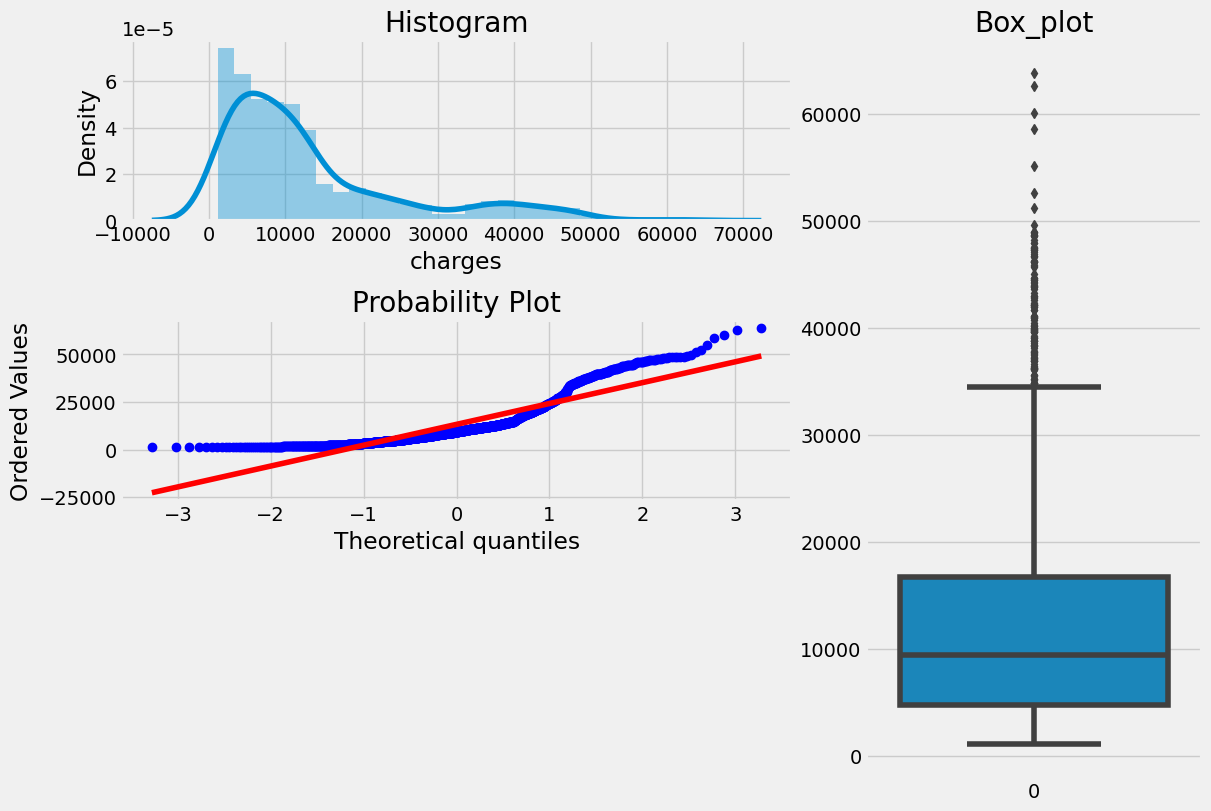

In [ ]:

plotting_3_charts(insur_df['charges'])

In [ ]:
#let's employ normal test to further check for the skewness. If the p-value is greater than 0.5 then it is skewed
normaltest(insur_df.charges.values)

NormaltestResult(statistic=336.4416065386955, pvalue=8.762608303862979e-74)

In [ ]:
#let's calculate the level of the skewness.
print(f'Skewness: {insur_df.charges.skew()}')

Skewness: 1.5153909108403483


**comment:**
*from our visualization and calculations, our target column, charges, is highly skewed towards the right direction, hence, we will need to transform it.*

***Log Transformation:***

<function __main__.plotting_3_charts(col)>

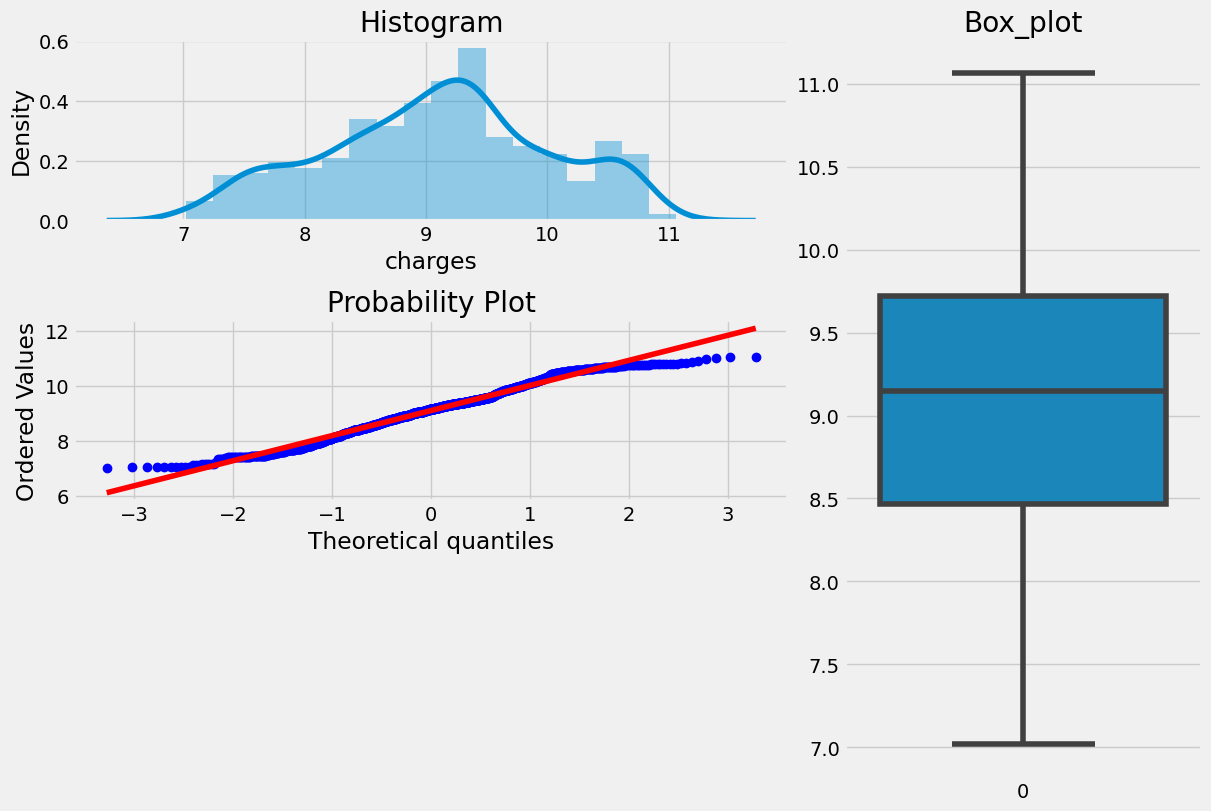

In [ ]:
#let's transform the charges column using log transformation
log_target = np.log(insur_df.charges)
#visualize the transformation with our function
plotting_3_charts(log_target)

In [ ]:
#let's employ normal test to further check for the skewness. If the p-value is greater than 0.5 then it is skewed
normaltest(log_target.values)

NormaltestResult(statistic=52.147628145443655, pvalue=4.745548606594116e-12)

In [ ]:
#let's the level of skewness
print(f'Skewness: {log_target.skew()}')

Skewness: -0.08983863481292871


***boxcox transformation:***

<function __main__.plotting_3_charts(col)>

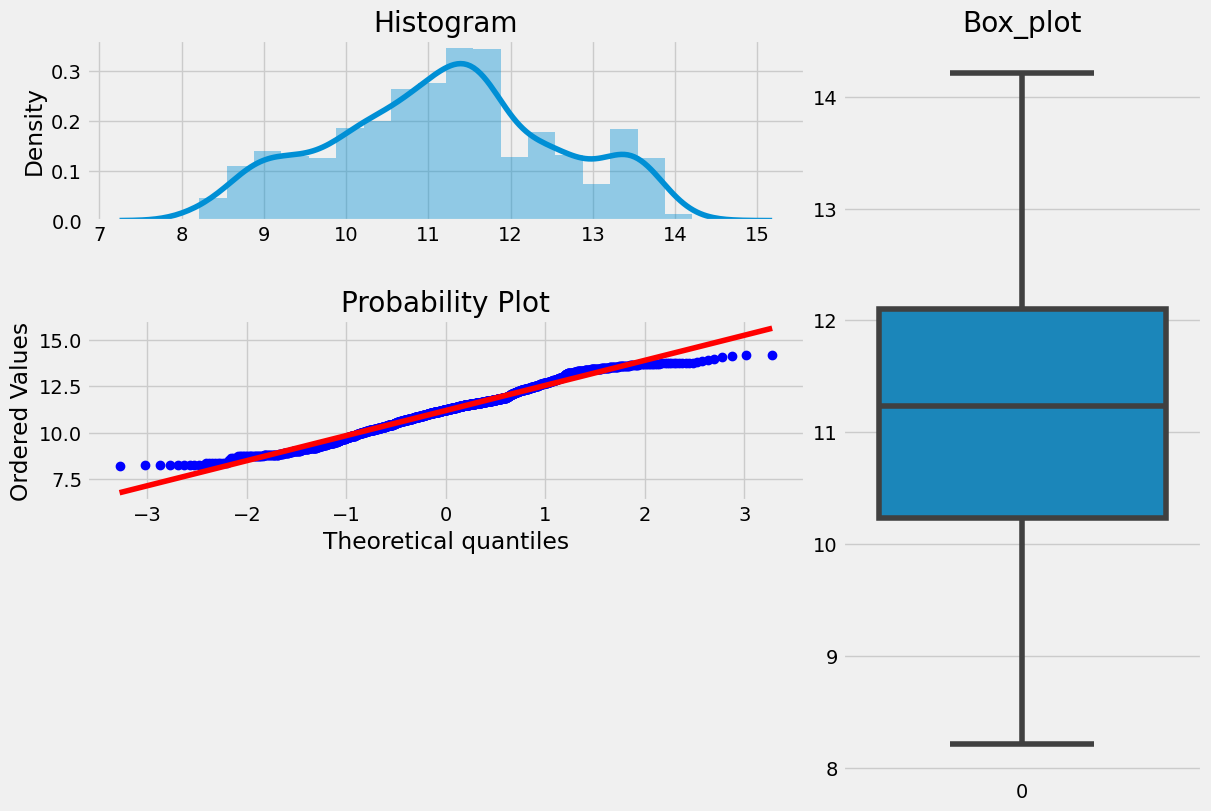

In [ ]:
#let's perform the a boxcox transformation
bc_result = boxcox(insur_df.charges)
boxcox_traget = bc_result[0]
lam1 = bc_result[1]
#plot
plotting_3_charts(boxcox_traget)

In [ ]:
#let's employ normal test to further check for the skewness. If the p-value is greater than 0.5 then it is skewed
normaltest(boxcox_traget)

NormaltestResult(statistic=53.89147995320849, pvalue=1.9843296302159134e-12)

In [ ]:
#let's check the level of skewness
print(f'Skewness: {pd.DataFrame(boxcox_traget).skew()}')

Skewness: 0   -0.008674
dtype: float64


*comment:*

boxcox did a better transformation than log transformation. However, the target column, charges, is not a little bit skewed towards to the left, henec, the negative sign.

**Let's check for outliers in our target column and fix it if there's any:**

**Let's calculate for outliers and drop them afterwards:**

In [ ]:
#calculate the interquartile range
q25 = insur_df['charges'].quantile(0.25)
q75 = insur_df['charges'].quantile(0.75)
iqr = q75 - q25
#calculate the high and low threshold beyond which a value will be considered as an outlier
low_threshold = q25 - (1.5*iqr)
high_threshold = q75 + (1.5 * iqr)
print(round(low_threshold,2))
print(round(high_threshold,2))

-13120.72
34524.78


In [ ]:
#let's identify the outliers
outliers = [x for x in insur_df['charges'] if x > high_threshold]
len(outliers)

139

In [ ]:
insur_df['charges'] =